# Computer Vision CSCI-GA.2272-001 Assignment 1, part 1.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch by modifying this ipython notebook (File-->Save a copy...).

To install PyTorch, follow instructions at http://pytorch.org/

Please submit your assignment by uploading this iPython notebook to Brightspace.

## Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 1 epoch (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [10%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [25%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist). Also, you may find training is faster if you use a GPU runtime (RunTime-->Change Runtime Type-->GPU). 

- Give a breakdown of the parameters within the above model, and the overall number.

WARMUP (5%)

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plotAccuracy(data1,data2):

  t = np.arange(0.0, len(data1), 1)
  s = data1

  fig, ax = plt.subplots()
  ax.plot(t, data1)
  ax.plot(t, data2)
  plt.legend(["Training accuracy", "Validation accuracy"])

  ax.set(xlabel='Number of Epochs', ylabel='Accuracy',
        title='Convergence plots of accuracy')
  ax.grid()

  plt.show()

In [9]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training 
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


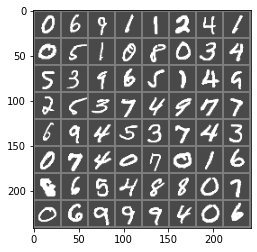

In [10]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(utils.make_grid(images))


In [11]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072
num_outputs = 10
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output
network1=Net(num_inputs, num_outputs) 
optimizer1 = optim.SGD(network1.parameters(), lr=lr)

In [12]:
trainingAccuracy=[0]
validationAccuracy=[0]
def train(epoch):
    network1.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer1.zero_grad()
        output = network1(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        optimizer1.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    trainingAccuracy.append(100. * correct / len(train_loader.dataset))
def test():
    network1.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network1(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    validationAccuracy.append(100. * correct / len(test_loader.dataset))

# Training a Single Layer Network on MNIST [10%] (a) training





In [13]:
for i in range(epochs):
  train(i)
  test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.417182
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.635809
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.477020
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.568290
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.307415
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.397132
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.350009
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.322607
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.356742
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.349110

Test set: Average loss: 0.3359, Accuracy: 9061/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.294953
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.316926
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.419099
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.291074
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.312122
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.282200
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.289180
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.225795
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.329390
T

# Training a Single Layer Network on MNIST [10%] (a)

Answer



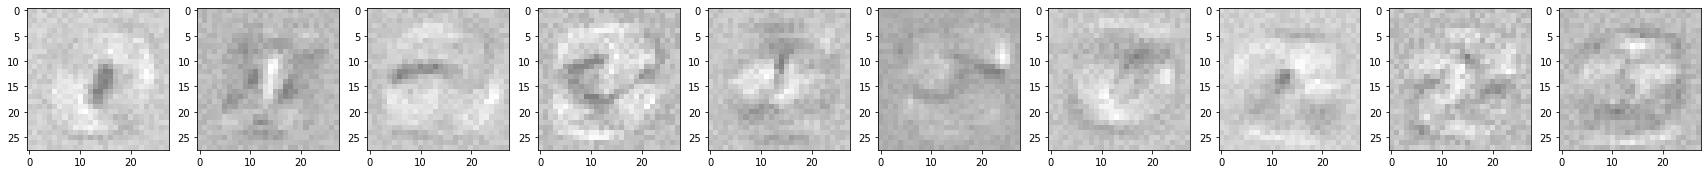

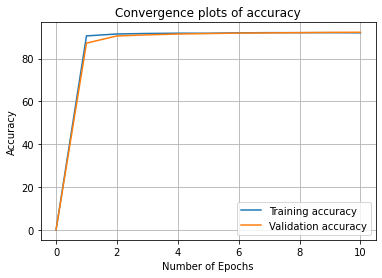

In [17]:
networkParams=list(network1.parameters())
import matplotlib.pyplot as plt
import numpy as np


def imshow(img,index):
    img = img / 2 + 0.5
    npimg = img.numpy()
    axarr[index].imshow(np.transpose(npimg, (1, 2, 0)))
    

weights=networkParams[0]
newWeights=[]

for i in range(len(weights)):
    newWeights.append(torch.reshape(weights[i],(28,28)))
f, axarr = plt.subplots(1,len(newWeights))
f.set_figheight(30)
f.set_figwidth(30)
for i in range(len(newWeights)):
    imshow(utils.make_grid(newWeights[i],normalize=True),i)

plt.show()
plotAccuracy(validationAccuracy,trainingAccuracy)


## Training a Single Layer Network on MNIST [10%] (b) solution:

In [4]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 50   # input batch size for (1b)
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate
# lr=10 #for 2b

In [5]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
import matplotlib.pyplot as plt
import numpy as np


if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072
num_outputs=10
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output
network2=Net(num_inputs, num_outputs) 
optimizer2 = optim.SGD(network2.parameters(), lr=lr)

In [7]:
def train(epoch):
    network2.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)

        data=data[:50]
        optimizer2.zero_grad()
        output = network2(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer2.step()
        break
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test():
    network2.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network2(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Training a Single Layer Network on MNIST [10%] (b) Answer

In [8]:
for i in range(epochs):
  train(i)
test()



Test set: Average loss: 1.5825, Accuracy: 5647/10000 (56%)



## Reducing the training example to just 50 will lead to incomplete training.So, the accuracy is reduced down to 56%.

## Training a Multi-Layer Network on MNIST [10%]



In [9]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   
epochs = 10       # number of epochs to train
# lr = 0.01        # learning rate
lr=10 #for 2b

In [10]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
import matplotlib.pyplot as plt
import numpy as np

if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072
  
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, 1000)
        self.linear2=nn.Linear(1000,num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output1 = self.linear(input)
        output = self.linear2(output1)
        m = nn.Tanh()
        return m(output)

network3 = Net(num_inputs, num_outputs)
optimizer3 = optim.SGD(network3.parameters(), lr=lr)

In [12]:
def train(epoch):
    network3.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer3.zero_grad()
        output = network3(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer3.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    network3.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network3(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# Training a Multi-Layer Network on MNIST [10%] (a)
Add an extra layer to the network with 1000 hidden units and a tanh non-linearity. [Hint: modify the Net class]. Train the model for 10 epochs and save the output into your report.

In [69]:
for i in range(10):
    train(i)
test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.357600
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.290072
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.172365
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.204321
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.134673
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.166683
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.065001
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.003758
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.060273
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.966638
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.058078
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.009435
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.041411
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.073269
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.024994
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.956390
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.031035
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.015154
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.013237
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.962600
Train Epoch:

## Training a Multi-Layer Network on MNIST [10%] (b) Learning rate=10

Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation


In [13]:
for i in range(10):
    train(i)
test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.359380
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.309569
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.573432
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.785232
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.821829
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.700612
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.789777
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.632758
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.481164
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.618121
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.515364
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.444442
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.273118
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.638695
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.588151
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.650651
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.515364
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.708008
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.577864
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.734114
Train Epoch:

**Increasing learning rate to 10 might cause overshooting of the gradient decent. When learning rate is large, gradient decent can overshoot the minimum. It may fail to converge, or even diverge.**


## Training a Convolutional Network on CIFAR [25%]

In [21]:
# options
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
batch_size = 64   
epochs = 20       # number of epochs to train
lr = 0.01        # learning rate

In [22]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
import matplotlib.pyplot as plt
import numpy as np

if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 128, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(128*5*5,64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):

        x = F.max_pool2d(torch.tanh(self.conv1(x)), (2, 2),stride=2)
        x = F.max_pool2d(torch.tanh(self.conv2(x)), (2, 2), stride=2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# network = Net(num_inputs, num_outputs) 
network4=Net() # part 3
optimizer4 = optim.SGD(network4.parameters(), lr=lr)

In [24]:
def train(epoch):
    # network4.cuda()
    network4.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        # data=data.cuda()
        # target=target.cuda()
        optimizer4.zero_grad()
        output = network4(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer4.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test():
    network4.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # data=data.cuda()
        # target=target.cuda()
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network4(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [25]:
for i in range(20):
  train(i)
test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [0/50000 (0%)]	Loss: 2.295664
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.178812
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.060090
Train Epoch: 0 [19200/50000 (38%)]	Loss: 2.008233
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.083753
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.888881
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.874570
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.839987
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.820723
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.728763
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.618446
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.683071
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.804282
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.632623
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.571386
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.502988
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.571761
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.522917
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.527452
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.709814
Train Epoch: 2 [25

## Training a Convolutional Network on CIFAR [25%] Answer


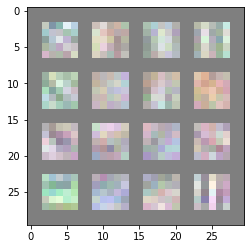

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
            Conv2d-2          [-1, 128, 10, 10]          51,328
            Linear-3                   [-1, 64]         204,864
            Linear-4                   [-1, 10]             650
Total params: 258,058
Trainable params: 258,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.19
Params size (MB): 0.98
Estimated Total Size (MB): 1.19
----------------------------------------------------------------


In [28]:
from torchvision import utils

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

kernels=network4.conv1.weight.detach().clone()

kernels=kernels-kernels.min()
kernels=kernels/kernels.max()
filter_img=utils.make_grid(kernels,nrow=4)
imshow(filter_img)

from torchsummary import summary
summary(network4,input_size=(3,32,32))